# Healthcare Dataset Stroke Prediction (Classification Model): Neural Network Training
## Binary dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import torch as t
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from   torch.autograd import Variable
from   torch.utils.tensorboard import SummaryWriter
import warnings

warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("classification_stroke_prediction.csv")

In [3]:
df_train.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [4]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Null Values

In [6]:
df_train.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Filling missing data

In [7]:
df_train['bmi'].fillna(df_train['bmi'].mean(),inplace=True)

In [8]:
df_train.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Drop excess columns 

In [9]:
df_train['gender'].value_counts()

# Drop others from gender column

df_train = df_train[df_train['gender'] != 'Other']
df_train['gender'].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

In [10]:
df_train =df_train.copy()
df_train = df_train.drop('id', axis=1)

In [11]:
df_train.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

### One hot Encoding (Categorical featrures)

In [12]:
print(df_train['ever_married'].value_counts())
df_married = pd.get_dummies(df_train['ever_married'])
df_married.columns = df_married.columns.str.replace('No', 'ever_married_no')
df_married.columns = df_married.columns.str.replace('Yes', 'ever_married_yes')
print(df_married[:5])

ever_married
Yes    3353
No     1756
Name: count, dtype: int64
   ever_married_no  ever_married_yes
0            False              True
1            False              True
2            False              True
3            False              True
4            False              True


In [13]:
print(df_train['gender'].value_counts())
df_gender = pd.get_dummies(df_train['gender'])
print(df_gender[:5])

gender
Female    2994
Male      2115
Name: count, dtype: int64
   Female   Male
0   False   True
1    True  False
2   False   True
3    True  False
4    True  False


In [14]:
print(df_train['work_type'].value_counts())
df_work_type = pd.get_dummies(df_train['work_type'])
print(df_work_type[:5])

work_type
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
   Govt_job  Never_worked  Private  Self-employed  children
0     False         False     True          False     False
1     False         False    False           True     False
2     False         False     True          False     False
3     False         False     True          False     False
4     False         False    False           True     False


In [15]:
print(df_train['Residence_type'].value_counts())
df_Residence_type = pd.get_dummies(df_train['Residence_type'])
print(df_Residence_type[:5])

Residence_type
Urban    2596
Rural    2513
Name: count, dtype: int64
   Rural  Urban
0  False   True
1   True  False
2   True  False
3  False   True
4   True  False


In [16]:
print(df_train['smoking_status'].value_counts())
df_smoking_status = pd.get_dummies(df_train['smoking_status'])
df_smoking_status.columns = df_smoking_status.columns.str.replace('Unknown', 'smoking_status_unknown')
df_smoking_status.columns = df_smoking_status.columns.str.replace(' ', '_')
print(df_smoking_status[:5])

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64
   smoking_status_unknown  formerly_smoked  never_smoked  smokes
0                   False             True         False   False
1                   False            False          True   False
2                   False            False          True   False
3                   False            False         False    True
4                   False            False          True   False


In [17]:
df_train_new = pd.concat([df_train, df_gender, df_married, df_Residence_type, df_smoking_status, df_work_type], axis =1)
print(df_train_new.columns)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'Female', 'Male', 'ever_married_no',
       'ever_married_yes', 'Rural', 'Urban', 'smoking_status_unknown',
       'formerly_smoked', 'never_smoked', 'smokes', 'Govt_job', 'Never_worked',
       'Private', 'Self-employed', 'children'],
      dtype='object')


In [18]:
df_train_new.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'Female', 'Male', 'ever_married_no',
       'ever_married_yes', 'Rural', 'Urban', 'smoking_status_unknown',
       'formerly_smoked', 'never_smoked', 'smokes', 'Govt_job', 'Never_worked',
       'Private', 'Self-employed', 'children'],
      dtype='object')

In [19]:
train_df= df_train_new.drop(columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], inplace = False)
print(train_df.columns)

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'Female', 'Male', 'ever_married_no', 'ever_married_yes',
       'Rural', 'Urban', 'smoking_status_unknown', 'formerly_smoked',
       'never_smoked', 'smokes', 'Govt_job', 'Never_worked', 'Private',
       'Self-employed', 'children'],
      dtype='object')


In [20]:
train_df.shape

(5109, 21)

### Correlation values 

In [21]:
corr_values = train_df.corr()
# corr_values
sorted_corr = corr_values.loc[:,'stroke'].sort_values() # Correlation values of all features with target value
# sorted_corr
print(sorted_corr)
column_corr = list(sorted_corr.index)  # Gives Feature names
# column_corr
selected_cols = column_corr[3:7]+column_corr[-9:] 
print(selected_cols)
df_select_train = df_train_new[selected_cols]

ever_married_no          -0.108299
children                 -0.083888
smoking_status_unknown   -0.055924
Rural                    -0.015415
Never_worked             -0.014885
Female                   -0.009081
never_smoked             -0.004163
Govt_job                  0.002660
smokes                    0.008920
Male                      0.009081
Private                   0.011927
Urban                     0.015415
bmi                       0.038912
Self-employed             0.062150
formerly_smoked           0.064683
ever_married_yes          0.108299
hypertension              0.127891
avg_glucose_level         0.131991
heart_disease             0.134905
age                       0.245239
stroke                    1.000000
Name: stroke, dtype: float64
['Rural', 'Never_worked', 'Female', 'never_smoked', 'bmi', 'Self-employed', 'formerly_smoked', 'ever_married_yes', 'hypertension', 'avg_glucose_level', 'heart_disease', 'age', 'stroke']


### Split data into training, validation

In [22]:
df_select_train.shape

(5109, 13)

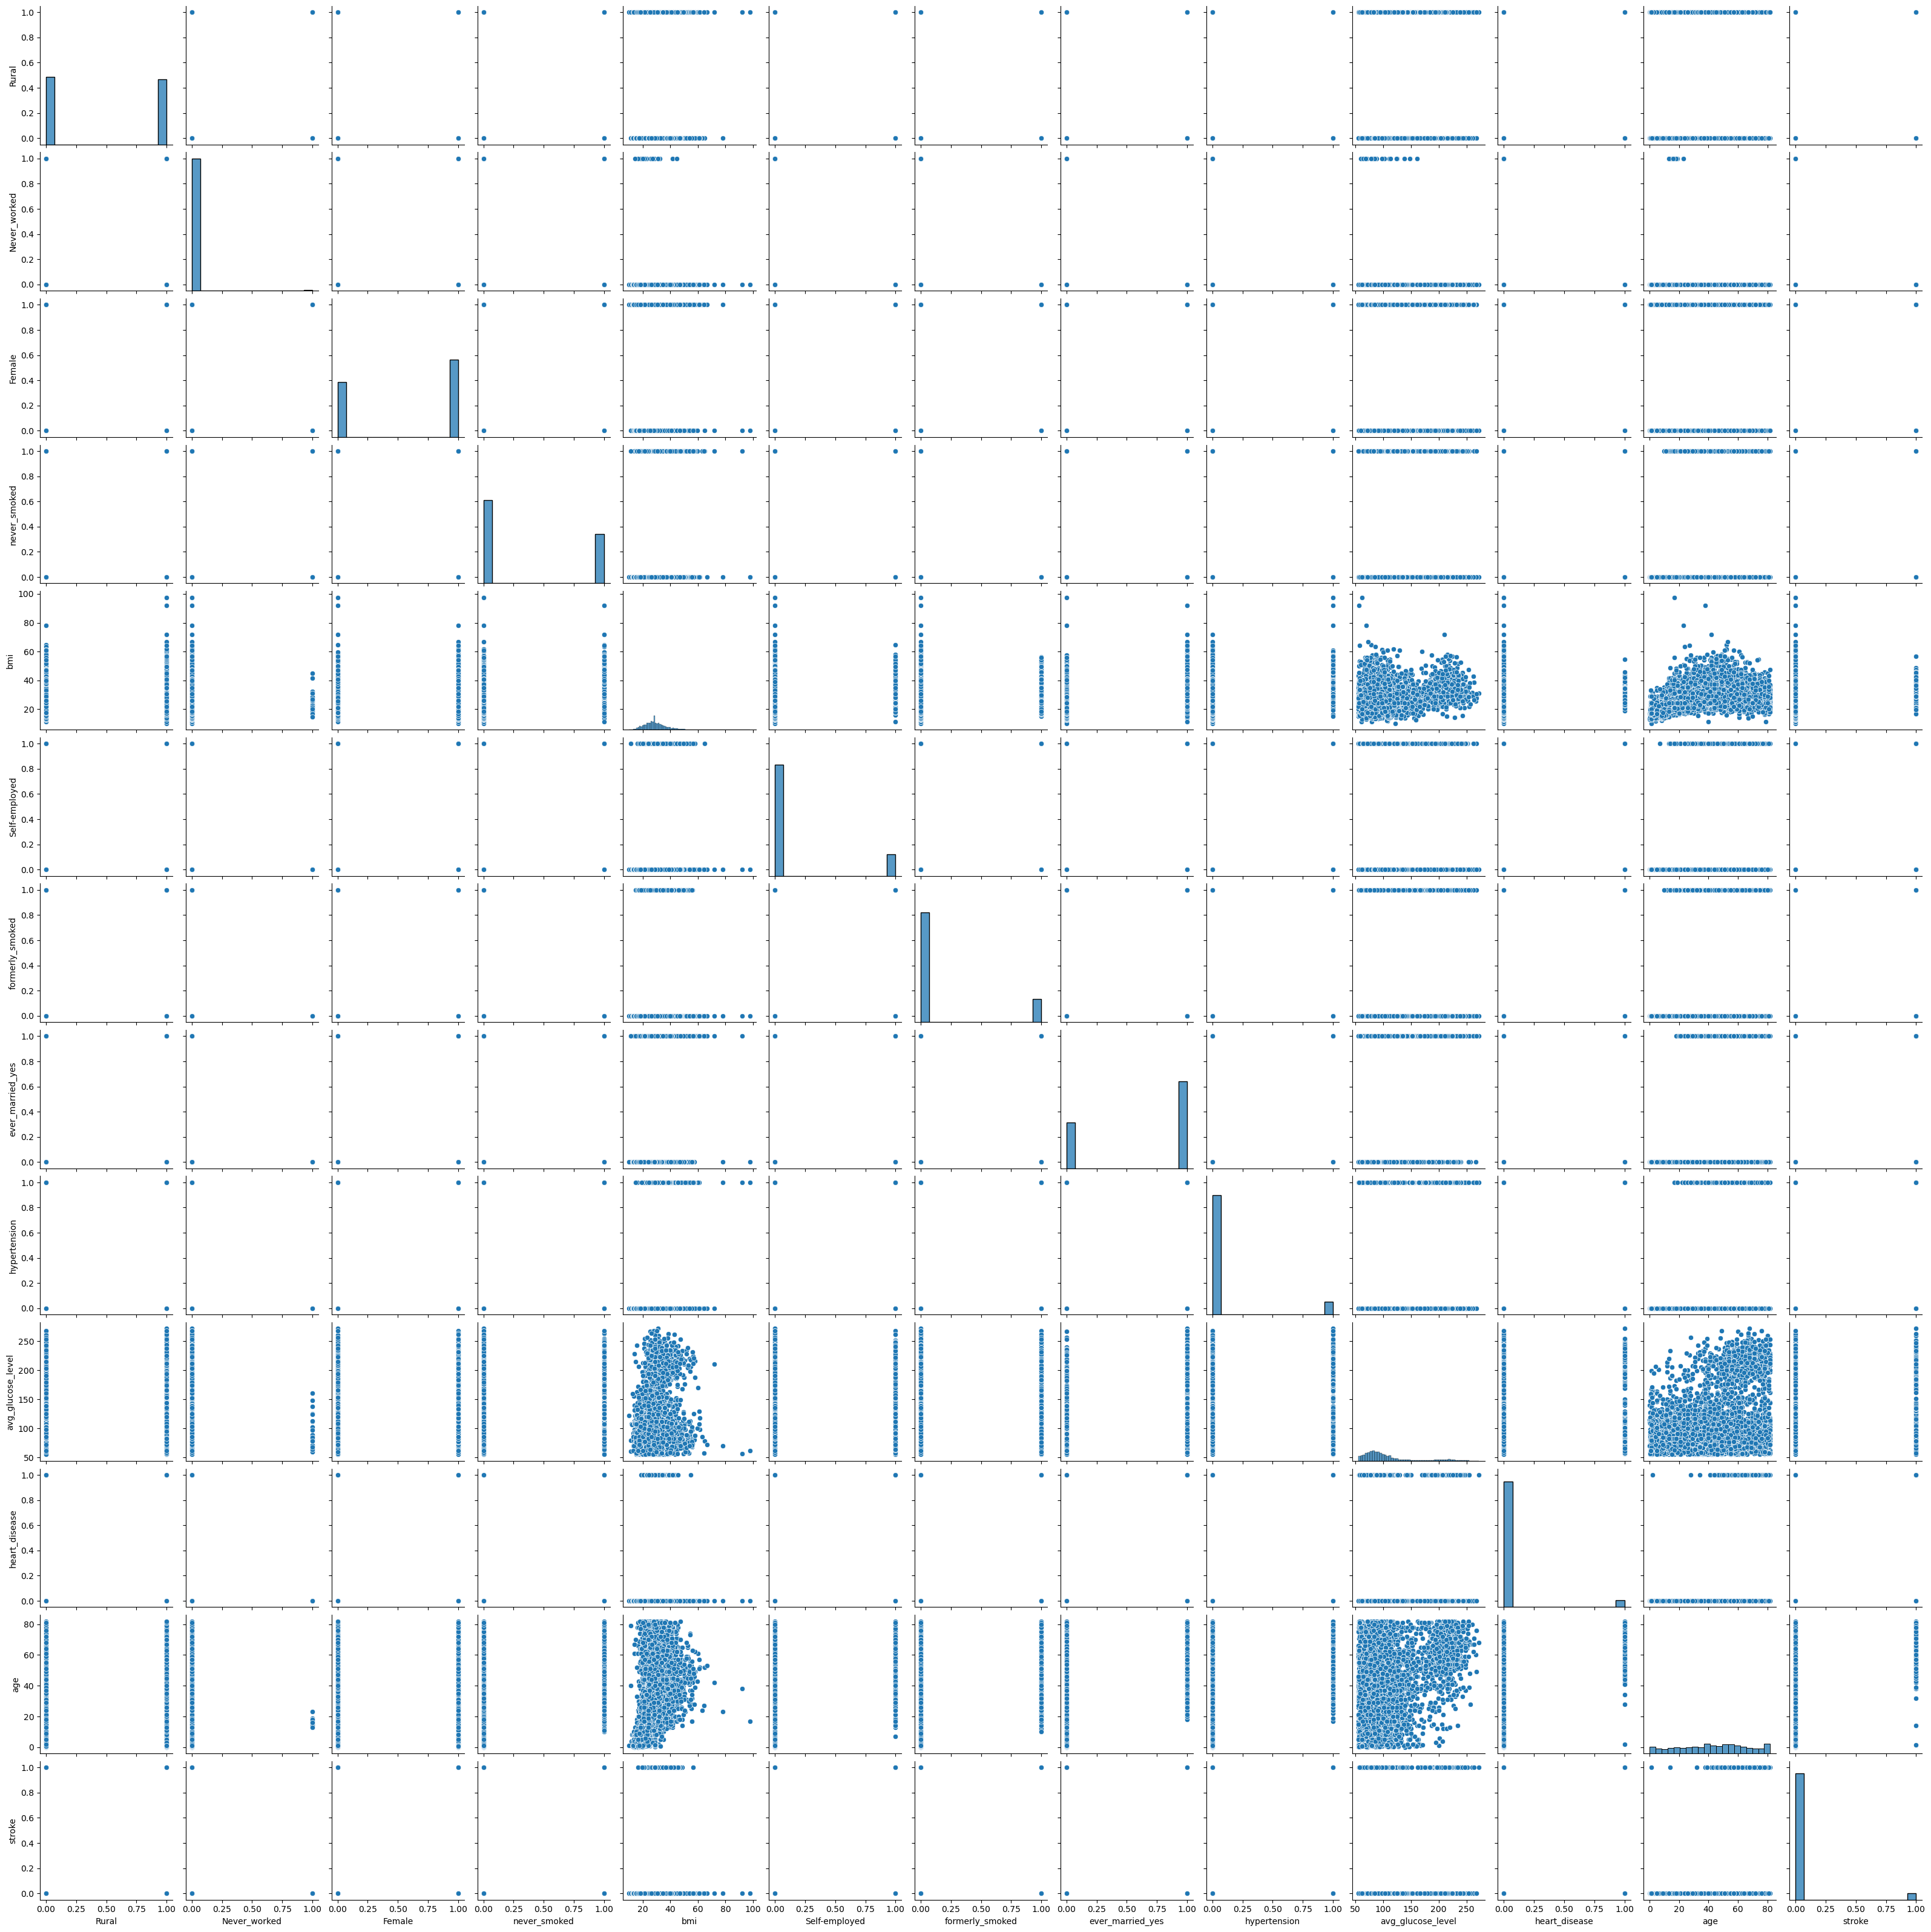

In [23]:
sns.pairplot(df_select_train)
plt.show()

In [24]:
# convert to pytorch tensors
y = t.tensor(df_select_train['stroke'].values,  dtype=t.float32).unsqueeze(1)
y.dtype

torch.float32

In [25]:
x_numpy = df_select_train.iloc[:,:-1].to_numpy(dtype = float)
X = t.tensor(x_numpy, dtype = t.float32)
X.dtype

torch.float32

In [26]:
X.shape

torch.Size([5109, 12])

In [27]:
y.shape

torch.Size([5109, 1])

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123, stratify= y)

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.fit_transform(x_test)

x_train_tensor = t.tensor(X_train_scaled, dtype = t.float32)
x_test_tensor = t.tensor(X_test_scaled, dtype = t.float32)


In [30]:
x_train_tensor.shape

torch.Size([4087, 12])

In [31]:
x_test_tensor.shape

torch.Size([1022, 12])

In [32]:
y_train.shape

torch.Size([4087, 1])

In [33]:
dataset_train = TensorDataset(x_train_tensor, y_train)
loader_train = DataLoader(dataset_train, batch_size = 32, shuffle=True)  

In [34]:
dataset_test = TensorDataset(x_test_tensor, y_test)
loader_test = DataLoader(dataset_test, batch_size= 32, shuffle=True)  

In [35]:
train_data = [(x_train_tensor[i], y_train[i]) for i in range(x_train_tensor.shape[0])]
print("Sample train_data = ", train_data[:3], " type = ", type(train_data))
trainloader = t.utils.data.DataLoader(train_data, batch_size = 16, shuffle=True)

test_data = [(x_test_tensor[i], y_test[i]) for i in range(x_test_tensor.shape[0])]
testloader = t.utils.data.DataLoader(test_data, batch_size = 8)

Sample train_data =  [(tensor([-0.9799, -0.0701,  0.8392,  1.3078, -0.2671, -0.4365, -0.4613,  0.7226,
        -0.3289, -0.5906, -0.2431,  1.6326]), tensor([0.])), (tensor([-0.9799, -0.0701, -1.1915, -0.7647, -0.1758, -0.4365,  2.1680,  0.7226,
        -0.3289,  0.8188, -0.2431,  1.5441]), tensor([0.])), (tensor([-0.9799, -0.0701,  0.8392,  1.3078,  1.1019, -0.4365, -0.4613,  0.7226,
        -0.3289, -0.3823, -0.2431, -0.5365]), tensor([0.]))]  type =  <class 'list'>


In [36]:
class Model(nn.Module):
    def __init__(self, input_dim = 4):

        super(Model, self).__init__()
        self.layer1    = nn.Linear(in_features = input_dim, out_features = 30)
        #self.dropout1 = nn.Dropout(p = 0.3) 
        self.layer2    = nn.Linear(in_features= 30, out_features = 20)
        #self.dropout2 = nn.Dropout(p = 0.25)
        self.layer3    = nn.Linear(in_features = 20, out_features = 10) 
        self.layer4    = nn.Linear(in_features = 10, out_features = 1 )


    def forward(self, x):
        x = F.relu(self.layer1(x)) # activation function is RELU (rectified linear unit)
        #x = self.dropout1(x)
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        # #x = self.dropout2(x)
        x = t.sigmoid(self.layer4(x)) # linear outout neurons - output can be negative/positive
        return x

In [37]:
model     = Model(x_train.shape[1])   # X_train.shape[1]
optimizer = t.optim.Adam(model.parameters(), lr=0.01)  #SGD = stochastic gradient descent
loss_fn   = nn.BCELoss() # loss function = CrossEntropyLoss
print(model)

writer = SummaryWriter("stroke/Prediction") 

Model(
  (layer1): Linear(in_features=12, out_features=30, bias=True)
  (layer2): Linear(in_features=30, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=10, bias=True)
  (layer4): Linear(in_features=10, out_features=1, bias=True)
)


In [38]:
epochs = 250  # or any number of epochs

for epoch in range(epochs):
    # === Training Phase ===
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch_x, batch_y in loader_train:
        optimizer.zero_grad()

        outputs = model(batch_x)  # shape: [batch_size, 1]
        loss = loss_fn(outputs, batch_y)  # BCEWithLogitsLoss

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * batch_y.size(0)

        preds = t.sigmoid(outputs) > 0.5
        correct_train += (preds.float() == batch_y).sum().item()
        total_train += batch_y.size(0)

    avg_train_loss = total_train_loss / total_train
    train_acc = correct_train / total_train

    # === Validation Phase ===
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    

    with t.no_grad():
        for batch_x, batch_y in loader_test:
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)

            total_val_loss += loss.item() * batch_y.size(0)

            preds = t.sigmoid(outputs) > 0.5
            correct_val += (preds.float() == batch_y).sum().item()
            total_val += batch_y.size(0)


    avg_val_loss = total_val_loss / total_val
    val_acc = correct_val / total_val

    # === Print Metrics ===
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")
        

Epoch 1/250 | Train Loss: 0.2089, Accuracy: 0.0487 | Val Loss: 0.1579, Accuracy: 0.0489
Epoch 10/250 | Train Loss: 0.1519, Accuracy: 0.0538 | Val Loss: 0.1582, Accuracy: 0.0509
Epoch 20/250 | Train Loss: 0.1433, Accuracy: 0.0644 | Val Loss: 0.1720, Accuracy: 0.0920
Epoch 30/250 | Train Loss: 0.1335, Accuracy: 0.0822 | Val Loss: 0.1846, Accuracy: 0.1380
Epoch 40/250 | Train Loss: 0.1229, Accuracy: 0.1343 | Val Loss: 0.2234, Accuracy: 0.0881
Epoch 50/250 | Train Loss: 0.1238, Accuracy: 0.1688 | Val Loss: 0.2237, Accuracy: 0.1409
Epoch 60/250 | Train Loss: 0.1152, Accuracy: 0.1879 | Val Loss: 0.2569, Accuracy: 0.1967
Epoch 70/250 | Train Loss: 0.1108, Accuracy: 0.2672 | Val Loss: 0.3098, Accuracy: 0.2701
Epoch 80/250 | Train Loss: 0.0991, Accuracy: 0.3345 | Val Loss: 0.3359, Accuracy: 0.3914
Epoch 90/250 | Train Loss: 0.0973, Accuracy: 0.3651 | Val Loss: 0.3496, Accuracy: 0.3777
Epoch 100/250 | Train Loss: 0.0999, Accuracy: 0.4081 | Val Loss: 0.3878, Accuracy: 0.4031
Epoch 110/250 | Train

In [39]:
from sklearn.metrics import confusion_matrix
model.eval()
all_preds = []
all_targets = []

with t.no_grad():
    for batch_x, batch_y in loader_test:
        outputs = model(batch_x)
        preds = t.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy().astype(int))
        all_targets.extend(batch_y.cpu().numpy().astype(int))

cm = confusion_matrix(all_targets, all_preds)
print("\nFinal Confusion Matrix:")
print(cm)


Final Confusion Matrix:
[[600 372]
 [ 11  39]]
